Setup

# Setup

In [1]:
# --- Install dependencies ---
!pip -q install pandas numpy scikit-learn matplotlib seaborn statsmodels
!pip -q install torch --index-url https://download.pytorch.org/whl/cpu
!pip -q install tabpfn
!pip install -U scikit-learn

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, accuracy_score,
                             f1_score, precision_recall_curve)

from tabpfn import TabPFNClassifier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7,5)

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Load dataset (note: stored inside eudirectlapse folder) ---
df = pd.read_csv("/content/drive/MyDrive/eudirectlapse/eudirectlapse.csv")
print("Shape:", df.shape)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (23060, 19)
   lapse  polholder_age polholder_BMCevol polholder_diffdriver  \
0      0             38            stable         only partner   
1      1             35            stable                 same   
2      1             29            stable                 same   
3      0             33              down                 same   
4      0             50            stable                 same   

  polholder_gender polholder_job  policy_age              policy_caruse  \
0             Male        normal           1  private or freelance work   
1             Male        normal           1  private or freelance work   
2             Male        normal           0  private or freelance work   
3           Female       medical           2  private or freelance work   
4             Male        normal           8                    unknown   

   p

# Task
Generate EDA plots to visualize the relationship between the 'lapse' variable and all other variables in the dataset.

## Identify variable types

### Categorical vs Numeric


In [2]:
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if df[col].dtype == 'object' or isinstance(df[col].dtype, pd.CategoricalDtype):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['polholder_BMCevol', 'polholder_diffdriver', 'polholder_gender', 'polholder_job', 'policy_caruse', 'prem_freqperyear', 'vehicl_garage', 'vehicl_powerkw', 'vehicl_region']
Numerical columns: ['lapse', 'polholder_age', 'policy_age', 'policy_nbcontract', 'prem_final', 'prem_last', 'prem_market', 'prem_pure', 'vehicl_age', 'vehicl_agepurchase']


## Visualize categorical variables


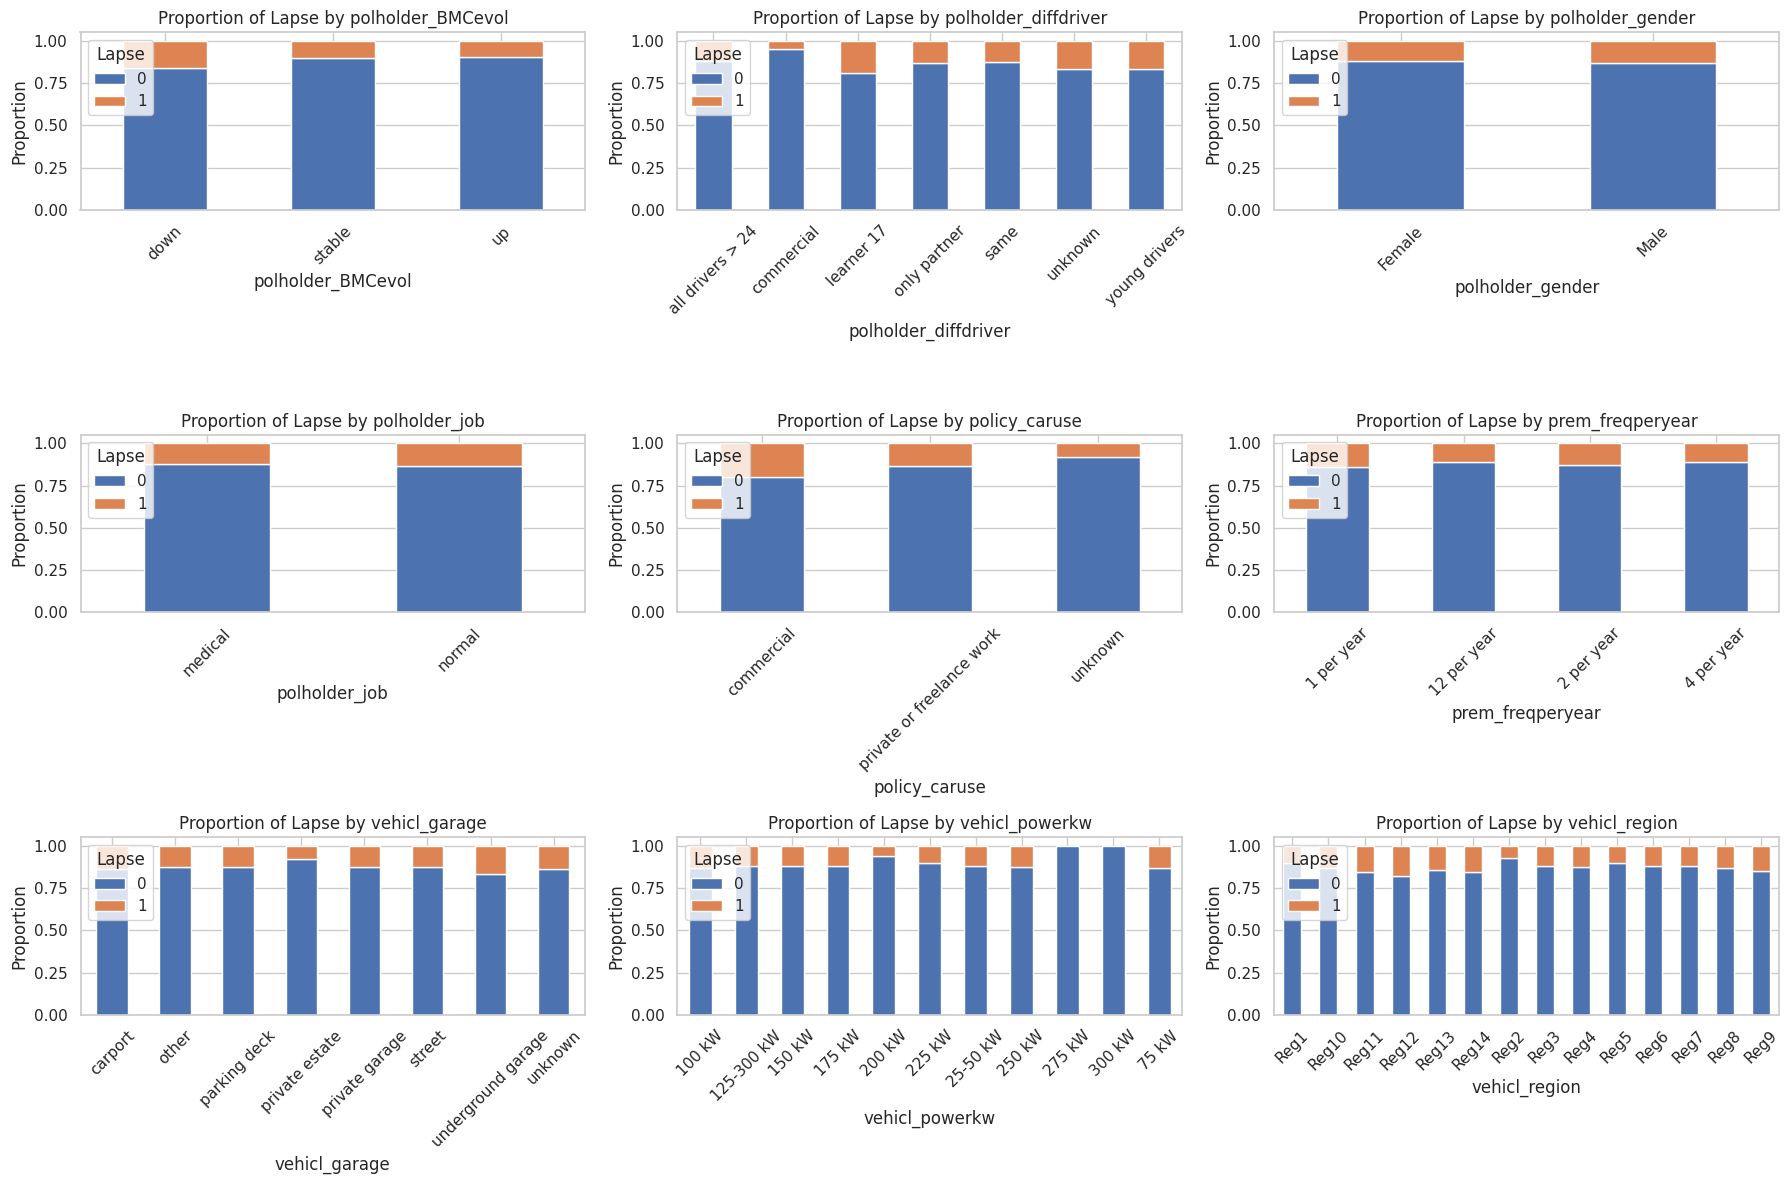

In [3]:
n_categorical_cols = len(categorical_cols) # Assuming 'lapse' is not in categorical_cols
n_cols = 3 # Number of columns in the subplot matrix
n_rows = (n_categorical_cols + n_cols - 1) // n_cols # Calculate the number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    if col != 'lapse': # Exclude the target variable itself
        ax = axes[i]
        grouped_data = df.groupby([col, 'lapse']).size().unstack(fill_value=0)
        proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0)
        proportions.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f'Proportion of Lapse by {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Proportion')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Lapse', loc='upper left')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [4]:
for col in categorical_cols:
    if col != 'lapse':  # Exclude the target variable itself
        print(f"Summary for '{col}':")
        # Group by the categorical column and lapse, then unstack to get counts
        grouped_counts = df.groupby([col, 'lapse']).size().unstack(fill_value=0)

        # Calculate total counts for each level
        total_counts = grouped_counts.sum(axis=1)

        # Calculate lapse rate
        # Avoid division by zero if total_counts is 0
        lapse_rate = grouped_counts[1] / total_counts if 1 in grouped_counts.columns else 0

        # Create a summary DataFrame
        summary_df = pd.DataFrame({
            'Non-Lapses': grouped_counts[0] if 0 in grouped_counts.columns else 0,
            'Lapses': grouped_counts[1] if 1 in grouped_counts.columns else 0,
            'Total': total_counts,
            'Lapse Rate': (lapse_rate * 100).round(1).astype(str) + '%'
        })

        display(summary_df)
        print("-" * 50)

Summary for 'polholder_BMCevol':


,Non-Lapses,Lapses,Total,Lapse Rate
polholder_BMCevol,,,,
down,8517,1638,10155,16.1%
stable,10805,1231,12036,10.2%
up,784,85,869,9.8%


--------------------------------------------------
Summary for 'polholder_diffdriver':


,Non-Lapses,Lapses,Total,Lapse Rate
polholder_diffdriver,,,,
all drivers > 24,1523,205,1728,11.9%
commercial,38,2,40,5.0%
learner 17,34,8,42,19.0%
only partner,7085,1043,8128,12.8%
same,9788,1367,11155,12.3%
unknown,10,2,12,16.7%
young drivers,1628,327,1955,16.7%


--------------------------------------------------
Summary for 'polholder_gender':


,Non-Lapses,Lapses,Total,Lapse Rate
polholder_gender,,,,
Female,7342,997,8339,12.0%
Male,12764,1957,14721,13.3%


--------------------------------------------------
Summary for 'polholder_job':


,Non-Lapses,Lapses,Total,Lapse Rate
polholder_job,,,,
medical,8338,1144,9482,12.1%
normal,11768,1810,13578,13.3%


--------------------------------------------------
Summary for 'policy_caruse':


,Non-Lapses,Lapses,Total,Lapse Rate
policy_caruse,,,,
commercial,8,2,10,20.0%
private or freelance work,16906,2661,19567,13.6%
unknown,3192,291,3483,8.4%


--------------------------------------------------
Summary for 'prem_freqperyear':


,Non-Lapses,Lapses,Total,Lapse Rate
prem_freqperyear,,,,
1 per year,10042,1638,11680,14.0%
12 per year,1929,247,2176,11.4%
2 per year,2692,398,3090,12.9%
4 per year,5443,671,6114,11.0%


--------------------------------------------------
Summary for 'vehicl_garage':


,Non-Lapses,Lapses,Total,Lapse Rate
vehicl_garage,,,,
carport,1220,193,1413,13.7%
other,1957,286,2243,12.8%
parking deck,1959,284,2243,12.7%
private estate,183,16,199,8.0%
private garage,7756,1107,8863,12.5%
street,4792,676,5468,12.4%
underground garage,881,175,1056,16.6%
unknown,1358,217,1575,13.8%


--------------------------------------------------
Summary for 'vehicl_powerkw':


,Non-Lapses,Lapses,Total,Lapse Rate
vehicl_powerkw,,,,
100 kW,4434,682,5116,13.3%
125-300 kW,1515,205,1720,11.9%
150 kW,510,70,580,12.1%
175 kW,181,25,206,12.1%
200 kW,30,2,32,6.2%
225 kW,69,8,77,10.4%
25-50 kW,4358,610,4968,12.3%
250 kW,14,2,16,12.5%
275 kW,4,0,4,0.0%


--------------------------------------------------
Summary for 'vehicl_region':


,Non-Lapses,Lapses,Total,Lapse Rate
vehicl_region,,,,
Reg1,553,65,618,10.5%
Reg10,918,139,1057,13.2%
Reg11,472,86,558,15.4%
Reg12,1086,239,1325,18.0%
Reg13,510,86,596,14.4%
Reg14,1085,204,1289,15.8%
Reg2,515,41,556,7.4%
Reg3,1604,223,1827,12.2%
Reg4,3777,548,4325,12.7%


--------------------------------------------------


## Visualize numerical variables


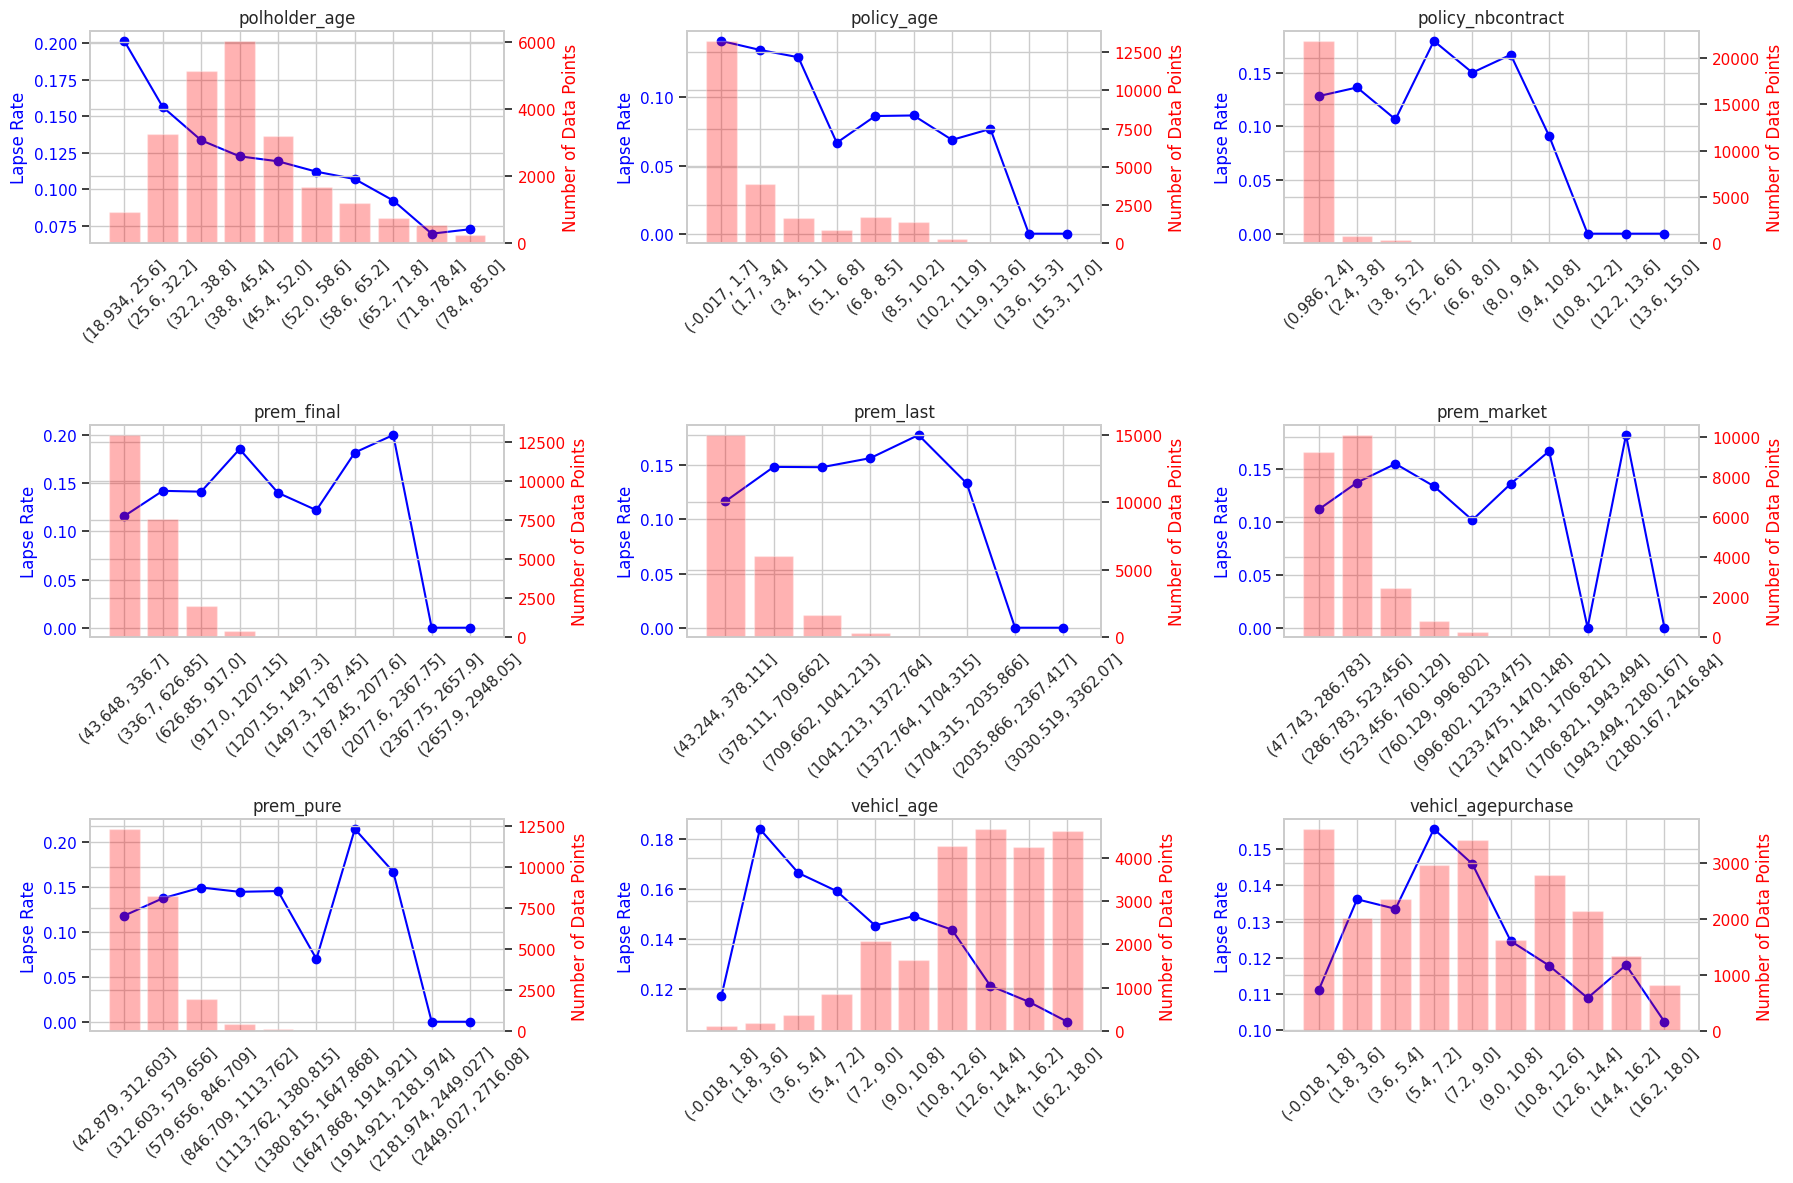

In [5]:
n_numerical_cols = len(numerical_cols) - 1 # Exclude 'lapse'
n_cols = 3 # Number of columns in the subplot matrix
n_rows = (n_numerical_cols + n_cols - 1) // n_cols # Calculate the number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate([c for c in numerical_cols if c != 'lapse']):  # Exclude 'lapse'
    ax1 = axes[i]
    # Create bins for the numerical variable
    df[f'{col}_bin'] = pd.cut(df[col], bins=10)  # Setting number of bins to 10 for visual smoothness

    # Calculate the mean lapse rate for each bin
    grouped_data = df.groupby(f'{col}_bin', observed=True)['lapse'].mean().reset_index()

    # Calculate the number of data points in each bin
    bin_counts = df.groupby(f'{col}_bin', observed=True).size().reset_index(name='count')

    # Plot the lapse rate
    ax1.plot(grouped_data[f'{col}_bin'].astype(str), grouped_data['lapse'], marker='o', color='blue')
    ax1.set_ylabel('Lapse Rate', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'{col}')

    # Create a second y-axis for the counts
    ax2 = ax1.twinx()
    ax2.bar(bin_counts[f'{col}_bin'].astype(str), bin_counts['count'], alpha=0.3, color='red')
    ax2.set_ylabel('Number of Data Points', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Drop the bin column
    df = df = df.drop(columns=[f'{col}_bin'])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Data Cleaning

From the categorical variable plot, it would seem that the lapse rate for vehicle power is very small. This could be due to small sample sizes which would give us sparse data problems. We investigate further

In [6]:
# Filter for 'vehicl_powerkw' == '275 kW' and 'lapse' == 0
count_275_no_lapse = df[(df['vehicl_powerkw'] == '275 kW') & (df['lapse'] == 0)].shape[0]
print(f"Number of data points for '275 kW' with no lapse: {count_275_no_lapse}")

# Filter for 'vehicl_powerkw' == '300 kW' and 'lapse' == 0
count_300_no_lapse = df[(df['vehicl_powerkw'] == '300 kW') & (df['lapse'] == 0)].shape[0]
print(f"Number of data points for '300 kW' with no lapse: {count_300_no_lapse}")

# Filter for 'vehicl_powerkw' == '125-300 kW' and 'lapse' == 0
count_125_300_no_lapse = df[(df['vehicl_powerkw'] == '125-300 kW') & (df['lapse'] == 0)].shape[0]
print(f"Number of data points for '125-300 kW' with no lapse: {count_125_300_no_lapse}")

# Additionally, let's check the total count for these categories
total_count_275 = df[df['vehicl_powerkw'] == '275 kW'].shape[0]
print(f"Total number of data points for '275 kW': {total_count_275}")

total_count_300 = df[df['vehicl_powerkw'] == '300 kW'].shape[0]
print(f"Total number of data points for '300 kW': {total_count_300}")

total_count_125_300 = df[df['vehicl_powerkw'] == '125-300 kW'].shape[0]
print(f"Total number of data points for '125-300 kW': {total_count_125_300}")

Number of data points for '275 kW' with no lapse: 4
Number of data points for '300 kW' with no lapse: 2
Number of data points for '125-300 kW' with no lapse: 1515
Total number of data points for '275 kW': 4
Total number of data points for '300 kW': 2
Total number of data points for '125-300 kW': 1720


In [7]:
# Replace '275 kW', '300 kW', '150 kW', '175 kW', '225 kW', '200 kW', and '250 kW' with '125-300 kW' in the 'vehicl_powerkw' column
df['vehicl_powerkw'] = df['vehicl_powerkw'].replace(['275 kW', '300 kW', '150 kW', '175 kW', '225 kW', '200 kW', '250 kW'], '125-300 kW')

# Verify the changes by checking the unique values in 'vehicl_powerkw' and their counts
print("Unique values and counts in 'vehicl_powerkw' after grouping:")
print(df['vehicl_powerkw'].value_counts())

Unique values and counts in 'vehicl_powerkw' after grouping:
vehicl_powerkw
75 kW         10339
100 kW         5116
25-50 kW       4968
125-300 kW     2637
Name: count, dtype: int64


# Task
Create a logistic GLM to predict the lapse rate based on all predictor variables in the dataset. Split the data into training and testing sets using stratified sampling, with 10,000 rows in each set. Present a summary of the GLM.

# Univariate GLMs
Fit all possible univariate logistic GLMs to predict 'lapse' and identify significant predictors.

## Prepare data

Ensure the data is prepared for modeling, including handling categorical variables.


In [11]:
# Separate target variable
y = df['lapse']

# Define feature variables X (all other columns)
X = df.drop('lapse', axis=1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (23060, 18)
Shape of y: (23060,)


## Iterate and fit univariate glms

### Subtask:
Loop through each predictor variable, fit a separate logistic GLM with 'lapse' as the dependent variable and the current predictor as the independent variable.


#Try Univariate Gender model first, as an illustration

In [12]:
import statsmodels.api as sm

# Prepare data for the GLM
X_gender = df['polholder_gender']
y = df['lapse']

# One-hot encode the 'polholder_gender' variable and convert to integer type
X_gender_encoded = pd.get_dummies(X_gender, prefix='polholder_gender', drop_first=True).astype(int)

# Add a constant to the predictor
X_gender_encoded = sm.add_constant(X_gender_encoded, prepend=False)

# Fit the logistic GLM
gender_glm = sm.Logit(y, X_gender_encoded).fit()

# Print the summary of the GLM
print(gender_glm.summary())

Optimization terminated successfully.
         Current function value: 0.382573
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  lapse   No. Observations:                23060
Model:                          Logit   Df Residuals:                    23058
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:               0.0004876
Time:                        12:36:22   Log-Likelihood:                -8822.1
converged:                       True   LL-Null:                       -8826.4
Covariance Type:            nonrobust   LLR p-value:                  0.003347
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
polholder_gender_Male     0.1214      0.042      2.920      0.004       0.040       0.

#Try Univariate polholder_BMCevol

In [13]:
import statsmodels.api as sm

# Prepare data for the GLM
X_bmc = df['polholder_BMCevol']
y = df['lapse']

# One-hot encode the 'polholder_BMCevol' variable and convert to integer type
X_bmc_encoded = pd.get_dummies(X_bmc, prefix='polholder_BMCevol', drop_first=True).astype(int)

# Add a constant to the predictor
X_bmc_encoded = sm.add_constant(X_bmc_encoded, prepend=False)

# Fit the logistic GLM
bmc_glm = sm.Logit(y, X_bmc_encoded).fit()

# Print the summary of the GLM
print(bmc_glm.summary())

Optimization terminated successfully.
         Current function value: 0.378904
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  lapse   No. Observations:                23060
Model:                          Logit   Df Residuals:                    23057
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                 0.01007
Time:                        12:36:24   Log-Likelihood:                -8737.5
converged:                       True   LL-Null:                       -8826.4
Covariance Type:            nonrobust   LLR p-value:                 2.422e-39
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
polholder_BMCevol_stable    -0.5236      0.040    -12.958      0.000      -0.603

#Output all Univariate Numeric GLM results

In [17]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Ensure df is loaded (assuming previous cells were run after restart)
if 'df' not in globals():
    print("DataFrame 'df' not found. Please run the data loading cell.")
else:
    # Separate target variable
    y = df['lapse']
    # Define feature variables X (all other columns)
    X = df.drop('lapse', axis=1)

    # Identify categorical and numerical columns again to ensure they are up-to-date
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

    print("Fitting univariate GLMs for numerical variables:")
    for col in numerical_cols:
        print(f"\n--- Variable: {col} ---")
        try:
            # Add a constant to the numerical variable
            X_const = sm.add_constant(X[col], prepend=True) # Prepend constant

            # Fit the GLM
            model = sm.Logit(y, X_const).fit(disp=0)
            print(model.summary())

        except np.linalg.LinAlgError as e:
            print(f"Could not fit GLM for {col}: Singular matrix. {e}")
        except Exception as e:
            print(f"Could not fit GLM for {col}: {e}")

        print("-" * 50) # Separator for summaries

Fitting univariate GLMs for numerical variables:

--- Variable: polholder_age ---
                           Logit Regression Results                           
Dep. Variable:                  lapse   No. Observations:                23060
Model:                          Logit   Df Residuals:                    23058
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                0.005524
Time:                        12:40:02   Log-Likelihood:                -8777.7
converged:                       True   LL-Null:                       -8826.4
Covariance Type:            nonrobust   LLR p-value:                 5.349e-23
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.2209      0.074    -16.572      0.000      -1.365      -1.076
polholder_age    -0.0165      0.002     

#Perform a train test split: 10k in each

In [19]:
from sklearn.model_selection import train_test_split

# Separate target variable
y = df['lapse']

# Define feature variables X (only numerical columns, excluding 'lapse')
# Assuming numerical_cols list is available from previous cells
if 'numerical_cols' not in globals():
    print("Error: 'numerical_cols' list not found. Please run the cell that identifies column types first.")
else:
    # Filter numerical_cols to exclude 'lapse' if it's present
    numerical_features = [col for col in numerical_cols if col != 'lapse']
    X = df[numerical_features]


    # Perform stratified train-test split with specified sizes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=10000,
        train_size=10000,
        stratify=y, # Stratify based on the target variable 'lapse'
        random_state=42 # for reproducibility
    )

    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)

    # Verify stratification (optional)
    print("\nProportion of 'lapse' in original data:", y.value_counts(normalize=True))
    print("Proportion of 'lapse' in y_train:", y_train.value_counts(normalize=True))
    print("Proportion of 'lapse' in y_test:", y_test.value_counts(normalize=True))

Shape of X_train: (10000, 9)
Shape of y_train: (10000,)
Shape of X_test: (10000, 9)
Shape of y_test: (10000,)

Proportion of 'lapse' in original data: lapse
0    0.871899
1    0.128101
Name: proportion, dtype: float64
Proportion of 'lapse' in y_train: lapse
0    0.8719
1    0.1281
Name: proportion, dtype: float64
Proportion of 'lapse' in y_test: lapse
0    0.8719
1    0.1281
Name: proportion, dtype: float64


In [22]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, f1_score

# Ensure X_train, X_test, y_train, y_test are available
if 'X_train' not in globals() or 'X_test' not in globals() or 'y_train' not in globals() or 'y_test' not in globals():
    print("Error: Training and testing data not found. Please run the train-test split cell first.")
else:
    # Add a constant to the training data for the GLM
    X_train_const = sm.add_constant(X_train, prepend=True)

    # Fit the multivariate logistic GLM on the training set
    print("Fitting multivariate logistic GLM...")
    multi_glm = sm.Logit(y_train, X_train_const).fit(disp=0)

    # Print the summary of the GLM
    print("\nMultivariate Logistic GLM Summary:")
    print(multi_glm.summary())

    # Evaluate the model on the training set
    print("\nEvaluating model performance on the training set (Default Threshold 0.5):")

    # Predict probabilities on the training set
    y_train_pred_prob = multi_glm.predict(X_train_const)

    # Convert probabilities to binary predictions (using a threshold of 0.5)
    y_train_pred_default = (y_train_pred_prob > 0.5).astype(int)

    # Calculate and print the Confusion Matrix for the training set (default threshold)
    conf_matrix_train_default = confusion_matrix(y_train, y_train_pred_default)
    print("\nConfusion Matrix (Training Set - Threshold 0.5):")
    print(conf_matrix_train_default)

    # Calculate and print the F1 Score for the training set (default threshold)
    f1_train_default = f1_score(y_train, y_train_pred_default)
    print(f"\nF1 Score (Training Set - Threshold 0.5): {f1_train_default:.4f}")


    # --- Evaluate on Training Set with Adjusted Threshold ---
    # Let's try the proportion of lapses in the training data as a threshold
    adjusted_threshold = y_train.mean()
    print(f"\nEvaluating model performance on the training set (Adjusted Threshold: {adjusted_threshold:.4f}):")

    y_train_pred_adjusted = (y_train_pred_prob > adjusted_threshold).astype(int)

    # Calculate and print the Confusion Matrix for the training set (adjusted threshold)
    conf_matrix_train_adjusted = confusion_matrix(y_train, y_train_pred_adjusted)
    print("\nConfusion Matrix (Training Set - Adjusted Threshold):")
    print(conf_matrix_train_adjusted)

    # Calculate and print the F1 Score for the training set (adjusted threshold)
    f1_train_adjusted = f1_score(y_train, y_train_pred_adjusted)
    print(f"\nF1 Score (Training Set - Adjusted Threshold): {f1_train_adjusted:.4f}")


    # Evaluate the model on the test set
    print("\nEvaluating model performance on the test set (Default Threshold 0.5):")

    # Add a constant to the test data for prediction
    X_test_const = sm.add_constant(X_test, prepend=True)

    # Predict probabilities on the test set
    y_test_pred_prob = multi_glm.predict(X_test_const)

    # Convert probabilities to binary predictions (using a threshold of 0.5)
    y_test_pred_default = (y_test_pred_prob > 0.5).astype(int)

    # Calculate and print the Confusion Matrix (default threshold)
    conf_matrix_test_default = confusion_matrix(y_test, y_test_pred_default)
    print("\nConfusion Matrix (Test Set - Threshold 0.5):")
    print(conf_matrix_test_default)

    # Calculate and print the F1 Score (default threshold)
    f1_test_default = f1_score(y_test, y_test_pred_default)
    print(f"\nF1 Score (Test Set - Threshold 0.5): {f1_test_default:.4f}")


    # --- Evaluate on Test Set with Adjusted Threshold ---
    print(f"\nEvaluating model performance on the test set (Adjusted Threshold: {adjusted_threshold:.4f}):")

    y_test_pred_adjusted = (y_test_pred_prob > adjusted_threshold).astype(int)

    # Calculate and print the Confusion Matrix (adjusted threshold)
    conf_matrix_test_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)
    print("\nConfusion Matrix (Test Set - Adjusted Threshold):")
    print(conf_matrix_test_adjusted)

    # Calculate and print the F1 Score (adjusted threshold)
    f1_test_adjusted = f1_score(y_test, y_test_pred_adjusted)
    print(f"\nF1 Score (Test Set - Adjusted Threshold): {f1_test_adjusted:.4f}")

Fitting multivariate logistic GLM...

Multivariate Logistic GLM Summary:
                           Logit Regression Results                           
Dep. Variable:                  lapse   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                 0.01468
Time:                        12:50:33   Log-Likelihood:                -3771.4
converged:                       True   LL-Null:                       -3827.6
Covariance Type:            nonrobust   LLR p-value:                 4.869e-20
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.9112      0.180     -5.069      0.000      -1.263      -0.559
polholder_age         -0.0116     

In [29]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Ensure training and testing data is available
if 'X_train' not in globals() or 'X_test' not in globals() or 'y_train' not in globals() or 'y_test' not in globals():
    print("Error: Training and testing data not found. Please run the train-test split cell first.")
else:
    # Initialize TabPFNClassifier
    # Set ignore_pretraining_limits=True to allow running on CPU with more than 1000 samples
    tabpfn = TabPFNClassifier()

    # Train the model
    print("Training TabPFN model...")
    tabpfn.fit(X_train, y_train)
    print("Training complete.")

    # Evaluate the model on the test set
    print("\nEvaluating TabPFN model performance on the test set:")

    # Predict on the test set
    y_pred = tabpfn.predict(X_test)

    # Calculate and print evaluation metrics (e.g., Accuracy, F1 Score)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)


    print(f"Accuracy on Test Set: {accuracy:.4f}")
    print(f"F1 Score on Test Set: {f1:.4f}")
    print("\nConfusion Matrix on Test Set:")
    print(conf_matrix)

Training TabPFN model...
Training complete.

Evaluating TabPFN model performance on the test set:
Accuracy on Test Set: 0.8719
F1 Score on Test Set: 0.0000

Confusion Matrix on Test Set:
[[8719    0]
 [1281    0]]
